# Classifying movie reviews: a binary classification example
In this example we will create a binary classifier to classify movie reviews as either positive or negative based on text of the reviews.

### 3.4.1 The IMDB dataset
We will work with the IMDB dataset which consists of 50,000 highly polarized reviews from IMDB. The data is split into 25,000 reviews for training and 25,000 for testing, each consisting of 50% negative and 50% positive reviews. The IMDB dataset comes packaged with Keras and has already been processed: the reviews (sequence of words) have been turned into sequences of integers where each integer stands for a specific word in a dictionary.

Let's load the dataset:

In [1]:
from keras.datasets import imdb

Using TensorFlow backend.


In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17448960/17464789 [============================>.] - ETA: 0s

The argument `num_words` means we will only keep the 10,000 most frequently occurring words in the training data. This allows us to work with vector data of manageable size. 

The variables `train_data` and `test_data` are lists of reviews; each is a list of word indices (encoding a sequence of words). `train_labels` and `test_labels` are lists of 0s and 1s, where 0 is **negative** and 1 is **positive**.

In [3]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [4]:
len(train_data[0])

218

In [5]:
train_labels[0]

1

In [6]:
# no word index should exceed 10,000
max([max(sequence) for sequence in train_data])

9999

In [7]:
# decode review back to English
word_index = imdb.get_word_index() #dictionary mapping words to integer index

# this reverses the dictionary so we return words instead of numbers
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# This decodes the review. Note indices are offset by 3 because 0, 1, & 2 are...
# reserved indices for "padding," "start of sequence," and "unknown"
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

1646592/1641221 [==============================] - 2s     


### 3.4.2 Preparing the data
You can't feed lists of integers into a neural network. You must turn your lists into tensors. There are two ways to do that:
 - Pad lists so they all have the same length, turn them into an integer tensor of shape (`samples, word_indices`), and then use the first layer in the network as a layer capable of handling such integer tensors (the `Embedding` layer).
 - **OR** One-hot encode the lists to turn them into vectors of 0s and 1s. This would mean turning the sequence [`3, 5`] into a 10,000-dimensional vector that would be all 0s except for indices 3 and 5, which would be 1s. Then you could use the first layer as a `Dense Layer`, capable of handling floating-point vector data.
 
We will go with the 2nd option of vectorizing the data:

In [8]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) # creates an all-zero matrix
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. # Sets specific indices of results[i] to 1s
    return results

# vectorize training data
x_train = vectorize_sequences(train_data)

# vectorize testing data
x_test = vectorize_sequences(test_data)

In [9]:
# What do samples look like now?
x_train[0]

array([ 0.,  1.,  1., ...,  0.,  0.,  0.])

In [10]:
len(x_train[0])

10000

In [12]:
# also vectorize the labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Now the data is ready to be fed into a neural network!

### 3.4.3 Building the network
The input data is vectors and the labels are scalars (1s and 0s). A type of network that performs well on this type of problem is a simple stack of fully connected (Dense) layers with `relu` activations.

The argument being passed to each `Dense` layer (16) is the number of hidden units of the layer. A *hidden unit* is a dimension in the representation space of the layer. Having 16 hidden units means the weight matrix `W` will have shape (`input_dimension, 16`): the dot product with `W` will project the input data onto a 16-dimensional representation space. The dimensionality of representation space is basically "how much freedom you're allowing the network to have when learning internal representations." More hidden units allows the network to learn more-complex representations, but the network becomes more computationally expensive and may lead to overfitting.

For this model, we will use:
 - Two intermediate layers with 16 hidden units each
 - A third layer will output the scalar prediction regarding the sentiment of the current review
 
The intermediate layers will use `relu` activation function, and the final layer will use a sigmoid activation so the output is a probability indicating how likely a sample is to have the target "1".

##### Rectified linear unit function
![relu](images/3_4_3_relu.jpg)

##### Sigmoid function
![sigmoid](images/3_4_3_sigmoid.jpg)

##### Our three-layer network
![network](images/3_4_3_network.jpg)


Here is the Keras implementation:

In [13]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Finally, we need to choose a loss function and an optimizer. Because we are facing a binary classification problem and the output of the network is a probability, it's best to use `binary_crossentropy` loss. Here, we will configure the model with the `rmsprop` optimizer and the `binary_crossentropy` loss function:

In [14]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Sometimes you may want to configure the parameters of your optimizer which can be done by passing an optimizer class instance at the `optimizer` argument:

In [17]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001), 
              loss='binary_crossentropy', metrics=['accuracy'])

Sometimes you may want to pass a custom loss function or metric function, which can be done by passing function objects as the `loss` and/or `metrics` arguments:

In [18]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy, 
              metrics=[metrics.binary_accuracy])

### 3.4.4 Validating approach
To monitor the accuracy of the model during training on data it has never seen before, we will create a validation set by setting apart 10,000 samples from the original training data:

In [19]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train the model for 20 epochs in mini-batches of 512 samples. We will also monitor the loss and accuracy on the 10,000 samples that we set apart. We do this by passing the validation data as the `validation_data` argument.

In [20]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 6s - loss: 0.5157 - acc: 0.7895 - val_loss: 0.4008 - val_acc: 0.8656
Epoch 2/20
15000/15000 [==============================] - 6s - loss: 0.3146 - acc: 0.9030 - val_loss: 0.3247 - val_acc: 0.8789
Epoch 3/20
15000/15000 [==============================] - 3s - loss: 0.2319 - acc: 0.9246 - val_loss: 0.2808 - val_acc: 0.8924
Epoch 4/20
15000/15000 [==============================] - 2s - loss: 0.1816 - acc: 0.9431 - val_loss: 0.2729 - val_acc: 0.8907
Epoch 5/20
15000/15000 [==============================] - 2s - loss: 0.1496 - acc: 0.9514 - val_loss: 0.2780 - val_acc: 0.8888
Epoch 6/20
15000/15000 [==============================] - 2s - loss: 0.1210 - acc: 0.9632 - val_loss: 0.3226 - val_acc: 0.8804
Epoch 7/20
15000/15000 [==============================] - 2s - loss: 0.1031 - acc: 0.9689 - val_loss: 0.3045 - val_acc: 0.8847
Epoch 8/20
15000/15000 [==============================] - 2s 

In [21]:
history_dict = history.history
history_dict.keys()

['acc', 'loss', 'val_acc', 'val_loss']

The call to `model.fit()` returns a `History` object that stores a dictionary containing data about everything that happened during training. The dictionary contains four entries: one per metric being measured during training and validation. Now let's plot the training and validation loss side by side, and then the training and validation side by side.

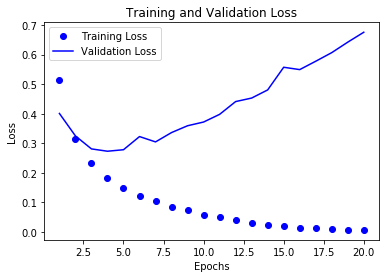

In [32]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

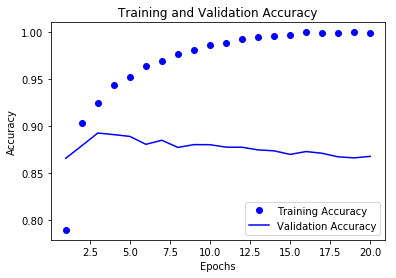

In [34]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

So let's unpack the plots above. The training loss decreases with every epoch, while the training accuracy increases with every epoch, which is what we would expect to happen with gradient descent. The validation loss and accuracy do not show the same trends, however. The validation loss seems to hit its lowest point around 4 epochs, and the validation accuracy peaks at around the same 4th epoch. What we are seeing here is a case of *overfitting*. We ended up learning representations that are specific to the training data, but don't generalize well to data outside of the training set.

Let's train a new network from scratch using four epochs and then evaluate it on test data.

In [35]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 6s - loss: 0.4704 - acc: 0.8107     
Epoch 2/4
25000/25000 [==============================] - 3s - loss: 0.2649 - acc: 0.9076     
Epoch 3/4
25000/25000 [==============================] - 3s - loss: 0.2023 - acc: 0.9275     
Epoch 4/4
24864/25000 [============================>.] - ETA: 0s

In [36]:
results

[0.29129809645652771, 0.88548000000000004]

With this fairly naive approach, we achieved an accuracy of 88%. With state-of-the-art approaches, we should be able to get close to 95%.

### 3.4.5 Using a trained network to generate predictions on new data
After training a network, we'll want to use it in a practical setting, so we will generate the likelihood of reviews being positive by using the `predict` method:

In [37]:
model.predict(x_test)

array([[ 0.92421025],
       [ 0.83551949],
       [ 0.99949062],
       ..., 
       [ 0.44672826],
       [ 0.0036482 ],
       [ 0.81084663]], dtype=float32)

The numbers above indicate percentages indicating a confidence level for positive (closer to 1) and negative reviews (closer to 0). We also see that the network is not extremely confident in its classification on samples where the predictions are around 0.4 or 0.6.

### 3.4.6 Further experiments

### Using three hidden layers instead of two

In [38]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
25000/25000 [==============================] - 6s - loss: 0.4772 - acc: 0.7932     
Epoch 2/4
25000/25000 [==============================] - 3s - loss: 0.2578 - acc: 0.9100     
Epoch 3/4
25000/25000 [==============================] - 3s - loss: 0.1960 - acc: 0.9288     
Epoch 4/4
25000/25000 [==============================] - 5s     


[0.30483594050407409, 0.88131999999999999]

**Accuracy went down from 88.5% to 88.1%**

### Changing the number of hidden units from 16 to 32

In [39]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
25000/25000 [==============================] - 6s - loss: 0.4297 - acc: 0.8250     
Epoch 2/4
25000/25000 [==============================] - 3s - loss: 0.2443 - acc: 0.9103     
Epoch 3/4
25000/25000 [==============================] - 3s - loss: 0.1897 - acc: 0.9298     
Epoch 4/4
24928/25000 [============================>.] - ETA: 0s

[0.3116677111721039, 0.87927999999999995]

**Accuracy went down from 88.5% to 87.9%**

### Changing the number of hidden units from 16 to 64


In [40]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
25000/25000 [==============================] - 8s - loss: 0.4196 - acc: 0.8129     - ETA: 5s
Epoch 2/4
25000/25000 [==============================] - 5s - loss: 0.2372 - acc: 0.9091     - ETA: 3s
Epoch 3/4
25000/25000 [==============================] - 4s - loss: 0.1829 - acc: 0.9300     
Epoch 4/4
24960/25000 [============================>.] - ETA: 0s

[0.3292320645189285, 0.87716000000000005]

**Accuracy went down from 88.5% to 87.1%**

### Using the `mse` loss function instead of `binary_crossentropy`

In [41]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
25000/25000 [==============================] - 5s - loss: 0.1482 - acc: 0.8204     
Epoch 2/4
25000/25000 [==============================] - 3s - loss: 0.0764 - acc: 0.9121     
Epoch 3/4
25000/25000 [==============================] - 3s - loss: 0.0580 - acc: 0.9312     
Epoch 4/4
24864/25000 [============================>.] - ETA: 0s

[0.086584766408205033, 0.88180000000000003]

**Accuracy went down from 88.5% to 88.2%**

### Using the `tanh` activation instead of `relu`

In [42]:
model = models.Sequential()
model.add(layers.Dense(16, activation='tanh', input_shape=(10000,)))
model.add(layers.Dense(16, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
25000/25000 [==============================] - 5s - loss: 0.4294 - acc: 0.8306     
Epoch 2/4
25000/25000 [==============================] - 3s - loss: 0.2376 - acc: 0.9129     
Epoch 3/4
25000/25000 [==============================] - 3s - loss: 0.1793 - acc: 0.9346     
Epoch 4/4
24992/25000 [============================>.] - ETA: 0s

[0.3313264957141876, 0.87536000000000003]

**Accuracy went down from 88.5% to 87.5%**